# 🧠 Robot Navigation Neural Network Training
===========================================

**Step-by-step training and visualization of the goal-aware robot navigation neural network.**

## Features:
- ✅ **Goal-aware navigation** (11 features: 9 perception + 2 goal_delta) 🎯
- ✅ **Basic navigation** (9 features: perception only)
- ✅ **Wall padding** (12×12 environments with 1-cell borders)
- ✅ **Compass-like navigation** (goal direction awareness)
- ✅ **Flexible configuration**
- ✅ **Interactive visualization**

## Quick Start:
1. Edit configuration in Cell 1
2. Run cells sequentially
3. Visualize training progress
4. Analyze goal-aware vs basic performance


In [9]:
# 🎯 CONFIGURATION
# ================
USE_GOAL_AWARE = True    # True=goal-aware (11 features), False=basic (9 features)

# 📦 IMPORTS
# ==========
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

# Add project to path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Force reload modules to get latest changes
if 'core.pytorch_network' in sys.modules:
    del sys.modules['core.pytorch_network']
if 'scripts.train_nn' in sys.modules:
    del sys.modules['scripts.train_nn']

# Import training utilities
from scripts.train_nn import (
    load_data, prepare_data_loaders, create_model, create_trainer,
    get_predictions, calculate_metrics
)
from core.pytorch_network import load_config

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load configuration first
print("🧪 Loading configuration...")
config = load_config(goal_aware=USE_GOAL_AWARE)
print("✅ Configuration loaded from configs/nn_config.yaml")
print()

print("✅ Setup complete!")
print(f"\n🎯 CONFIGURATION")
print("=" * 50)
print(f"   Mode: {'Goal-Aware 🎯' if USE_GOAL_AWARE else 'Basic'}")
print(f"   Features: {config['model']['input_size']} ({'9 perception + 2 goal_delta' if USE_GOAL_AWARE else 'perception only'})")
print(f"   Architecture: {config['model']['input_size']} → {config['model']['hidden1_size']} → {config['model']['hidden2_size']} → {config['model']['output_size']}")
print(f"   Dropout Rate: {config['model']['dropout_rate']}")
print(f"   Learning Rate: {config['training']['learning_rate']}")

# Test the load_config function
print(f"\n🧪 Testing load_config function:")
print(f"   ✅ load_config(goal_aware={USE_GOAL_AWARE}) works!")
print(f"   Input size: {config['model']['input_size']}")
print(f"   Hidden layers: {config['model']['hidden1_size']} → {config['model']['hidden2_size']}")
print(f"   Dropout: {config['model']['dropout_rate']}")
print(f"   Learning rate: {config['training']['learning_rate']}")


🧪 Loading configuration...
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
🎯 Updated config for Goal-Aware Mode (11 features)
✅ Configuration loaded from configs/nn_config.yaml

✅ Setup complete!

🎯 CONFIGURATION
   Mode: Goal-Aware 🎯
   Features: 11 (9 perception + 2 goal_delta)
   Architecture: 11 → 128 → 64 → 4
   Dropout Rate: 0.15
   Learning Rate: 0.0005

🧪 Testing load_config function:
   ✅ load_config(goal_aware=True) works!
   Input size: 11
   Hidden layers: 128 → 64
   Dropout: 0.15
   Learning rate: 0.0005


In [10]:
# 📊 LOAD DATA
# ============

X, y, metadata, is_goal_aware = load_data(USE_GOAL_AWARE)
train_loader, val_loader, test_loader = prepare_data_loaders(X, y, config)

# Display sample data
print(f"\n📋 Sample Data:")
print(f"   Input shape: {X[0].shape}")
print(f"   Sample features: {X[0][:10]}...")
print(f"   Sample label: {y[0]}")

# Show goal delta if in goal-aware mode
if USE_GOAL_AWARE and X.shape[1] == 11:
    goal_delta = X[0][9:11]
    print(f"   Goal delta: ({goal_delta[0]:.0f}, {goal_delta[1]:.0f})")
    print(f"   Direction: {'UP' if goal_delta[0] < 0 else 'DOWN'} {'LEFT' if goal_delta[1] < 0 else 'RIGHT'}")
    print(f"   Distance: {abs(goal_delta[0]) + abs(goal_delta[1])} steps")


📂 Loading data: large_training_dataset.npz
📂 Training data loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/data/raw/large_training_dataset.npz
✅ Data loaded: 8761 samples
   Features: 11 (Goal-Aware 🎯)
   Environments: 1000
📊 Data splits:
   Train: 7007 samples
   Validation: 877 samples
   Test: 877 samples

📋 Sample Data:
   Input shape: (11,)
   Sample features: [0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]...
   Sample label: 1
   Goal delta: (4, -1)
   Direction: DOWN LEFT
   Distance: 5.0 steps


In [11]:
# 🧠 CREATE MODEL
# ===============
model = create_model(config)
trainer = create_trainer(model, config)

print(f"\n📝 Training Configuration:")
print(f"   Epochs: {config['training']['epochs']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Early stopping: {config['training']['early_stopping']['patience']} epochs")



📝 Training Configuration:
   Epochs: 300
   Batch size: 64
   Early stopping: 55 epochs


In [12]:
# 🔥 TRAIN MODEL
# ==============
print(f"🚀 Starting training...")
print("=" * 60)

history = trainer.train(
    train_loader,
    val_loader,
    epochs=config['training']['epochs'],
    early_stopping_patience=config['training']['early_stopping']['patience'],
    verbose=True
)

print(f"\n✅ Training completed!")
print(f"   Epochs trained: {len(history['train_losses'])}")
print(f"   Best validation accuracy: {max(history['val_accuracies']):.4f}")


🚀 Starting training...
🚀 Starting training on cpu
🧠 Architecture: 11 → 128 → 64 → 4
⚙️  Learning rate: 0.0005
🛡️  Dropout rate: 0.15
------------------------------------------------------------
Epoch   0: Train Loss=1.1763, Train Acc=64.78%, Val Loss=1.0416, Val Acc=76.17%
Epoch  10: Train Loss=0.8824, Train Acc=87.07%, Val Loss=0.8780, Val Acc=87.00%
Epoch  20: Train Loss=0.8626, Train Acc=88.44%, Val Loss=0.8659, Val Acc=87.69%
Epoch  30: Train Loss=0.8576, Train Acc=88.95%, Val Loss=0.8573, Val Acc=88.48%
Epoch  40: Train Loss=0.8510, Train Acc=89.35%, Val Loss=0.8541, Val Acc=88.94%
Epoch  50: Train Loss=0.8475, Train Acc=89.77%, Val Loss=0.8578, Val Acc=88.71%
Epoch  60: Train Loss=0.8476, Train Acc=89.52%, Val Loss=0.8576, Val Acc=88.37%
Epoch  70: Train Loss=0.8454, Train Acc=90.02%, Val Loss=0.8552, Val Acc=88.48%
Epoch  80: Train Loss=0.8420, Train Acc=90.21%, Val Loss=0.8558, Val Acc=88.71%
Epoch  90: Train Loss=0.8402, Train Acc=90.42%, Val Loss=0.8558, Val Acc=88.60%
Epoch 

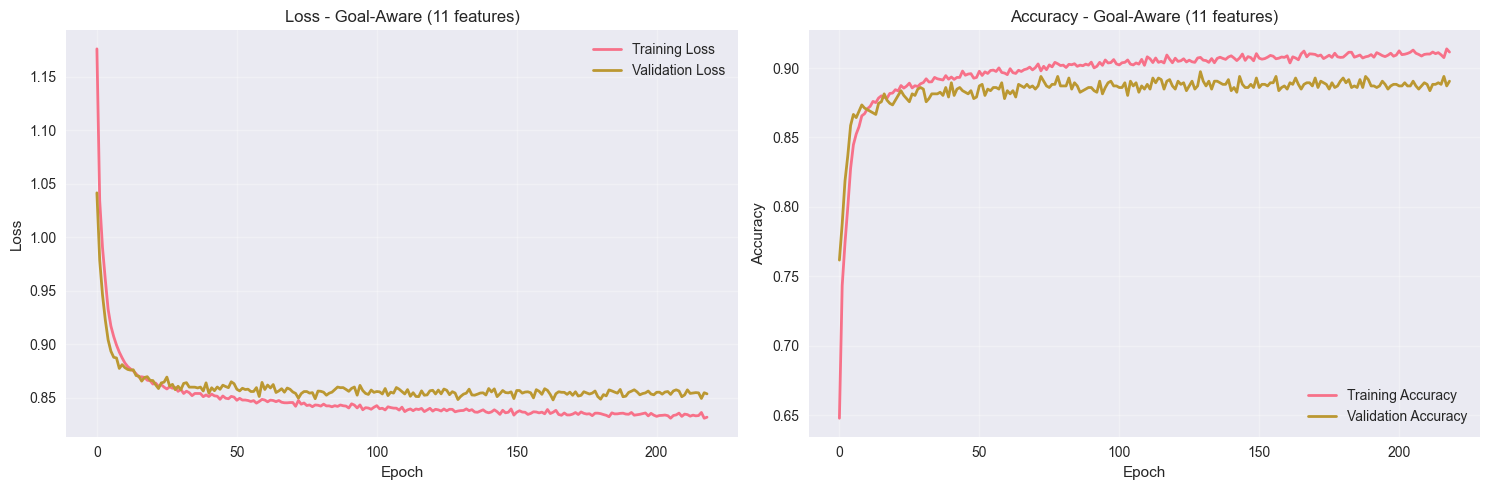


📊 Training Analysis:
   Training Accuracy: 0.9115 (91.2%)
   Validation Accuracy: 0.8905 (89.1%)
   Overfitting Gap: 0.0210 (2.1%)
✅ Excellent: No overfitting

🎯 Performance vs Expected:
   Expected Accuracy: 80%
   Actual Accuracy: 89.1%
   Difference: +0.1%


In [14]:
# 📈 VISUALIZE TRAINING HISTORY
# =============================
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

mode_name = "Goal-Aware" if USE_GOAL_AWARE else "Basic"
feature_desc = "11 features" if USE_GOAL_AWARE else "9 features"

# Loss plot
axes[0].plot(history['train_losses'], label='Training Loss', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation Loss', linewidth=2)
axes[0].set_title(f'Loss - {mode_name} ({feature_desc})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracies'], label='Training Accuracy', linewidth=2)
axes[1].plot(history['val_accuracies'], label='Validation Accuracy', linewidth=2)
axes[1].set_title(f'Accuracy - {mode_name} ({feature_desc})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print analysis
final_train_acc = history['train_accuracies'][-1]
final_val_acc = history['val_accuracies'][-1]
overfitting = final_train_acc - final_val_acc

print(f"\n📊 Training Analysis:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   Overfitting Gap: {overfitting:.4f} ({overfitting*100:.1f}%)")

if overfitting > 0.1:
    print(f"⚠️  Warning: Significant overfitting")
elif overfitting > 0.05:
    print(f"✅ Acceptable: Minimal overfitting")
else:
    print(f"✅ Excellent: No overfitting")

# Performance comparison
expected_acc = 0.80 if USE_GOAL_AWARE else 0.70
performance_vs_expected = final_val_acc - expected_acc
print(f"\n🎯 Performance vs Expected:")
print(f"   Expected Accuracy: {expected_acc*100:.0f}%")
print(f"   Actual Accuracy: {final_val_acc*100:.1f}%")
print(f"   Difference: {performance_vs_expected:+.1f}%")


In [ ]:
# 🎯 TEST SET EVALUATION
# ======================
test_accuracy, test_loss = trainer.evaluate(test_loader)

print(f"📊 Test Set Performance:")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   Loss: {test_loss:.4f}")

# Get predictions for detailed analysis
predictions, targets = get_predictions(model, test_loader, trainer.device)
metrics = calculate_metrics(predictions, targets)

print(f"\n📋 Detailed Metrics:")
print(f"   Precision: {metrics['precision']:.4f}")
print(f"   Recall: {metrics['recall']:.4f}")
print(f"   F1-Score: {metrics['f1']:.4f}")


In [ ]:
# 📊 CONFUSION MATRIX
# ===================
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=action_names, yticklabels=action_names)
plt.title(f'Confusion Matrix - {mode_name} ({feature_desc})')
plt.xlabel('Predicted Action')
plt.ylabel('True Action')
plt.show()

# Classification report
print(f"\n📋 Classification Report:")
print(classification_report(targets, predictions, target_names=action_names))

# Goal-aware specific analysis
if USE_GOAL_AWARE and X.shape[1] == 11:
    print(f"\n🧭 Goal-Aware Navigation Analysis:")
    print("=" * 40)
    
    # Get test data for goal delta analysis
    test_data = []
    test_targets = []
    for batch_data, batch_targets in test_loader:
        test_data.append(batch_data.numpy())
        test_targets.append(batch_targets.numpy())
    
    X_test = np.vstack(test_data)
    y_test = np.hstack(test_targets)
    
    # Analyze goal delta patterns for correct vs incorrect predictions
    correct_mask = predictions == targets
    incorrect_mask = predictions != targets
    
    if np.sum(correct_mask) > 0 and np.sum(incorrect_mask) > 0:
        correct_dx = X_test[correct_mask, 9]
        correct_dy = X_test[correct_mask, 10]
        incorrect_dx = X_test[incorrect_mask, 9]
        incorrect_dy = X_test[incorrect_mask, 10]
        
        print(f"   Correct predictions: {np.sum(correct_mask)}")
        print(f"     Avg distance to goal: {(np.abs(correct_dx) + np.abs(correct_dy)).mean():.1f} steps")
        print(f"   Incorrect predictions: {np.sum(incorrect_mask)}")
        print(f"     Avg distance to goal: {(np.abs(incorrect_dx) + np.abs(incorrect_dy)).mean():.1f} steps")
        
        # Check if goal-aware navigation is working
        goal_alignment_score = 0
        for action_idx, action_name in enumerate(action_names):
            action_mask = targets == action_idx
            if np.sum(action_mask) > 0:
                action_dx = X_test[action_mask, 9]
                action_dy = X_test[action_mask, 10]
                
                # Check if action aligns with goal direction
                if action_name == "UP" and np.mean(action_dx) < 0:
                    goal_alignment_score += 1
                elif action_name == "DOWN" and np.mean(action_dx) > 0:
                    goal_alignment_score += 1
                elif action_name == "LEFT" and np.mean(action_dy) < 0:
                    goal_alignment_score += 1
                elif action_name == "RIGHT" and np.mean(action_dy) > 0:
                    goal_alignment_score += 1
        
        alignment_percentage = (goal_alignment_score / 4) * 100
        print(f"   Goal alignment score: {goal_alignment_score}/4 ({alignment_percentage:.0f}%)")
        
        if alignment_percentage >= 75:
            print(f"   ✅ Excellent goal-aware navigation!")
        elif alignment_percentage >= 50:
            print(f"   ✅ Good goal-aware navigation")
        else:
            print(f"   ⚠️  Goal-aware navigation needs improvement")


In [ ]:
# Visualize goal delta patterns for different actions
if USE_GOAL_AWARE and X.shape[1] == 11:
    print("🧭 GOAL DELTA PATTERNS BY ACTION")
    print("=" * 50)
    
    # Get test data for visualization
    test_data = []
    test_targets = []
    for batch_data, batch_targets in test_loader:
        test_data.append(batch_data.numpy())
        test_targets.append(batch_targets.numpy())
    
    X_test = np.vstack(test_data)
    y_test = np.hstack(test_targets)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for action_idx, action_name in enumerate(action_names):
        action_mask = y_test == action_idx
        if np.sum(action_mask) > 0:
            action_dx = X_test[action_mask, 9]
            action_dy = X_test[action_mask, 10]
            
            # Create scatter plot
            scatter = axes[action_idx].scatter(action_dy, action_dx, alpha=0.6, s=20)
            axes[action_idx].set_title(f'{action_name} Actions')
            axes[action_idx].set_xlabel('DY (Horizontal)')
            axes[action_idx].set_ylabel('DX (Vertical)')
            axes[action_idx].grid(True, alpha=0.3)
            
            # Add quadrant lines
            axes[action_idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
            axes[action_idx].axvline(x=0, color='black', linestyle='--', alpha=0.5)
            
            # Add quadrant labels
            axes[action_idx].text(0.02, 0.98, 'UP-LEFT', transform=axes[action_idx].transAxes, 
                                ha='left', va='top', fontsize=8, alpha=0.7)
            axes[action_idx].text(0.98, 0.98, 'UP-RIGHT', transform=axes[action_idx].transAxes, 
                                ha='right', va='top', fontsize=8, alpha=0.7)
            axes[action_idx].text(0.02, 0.02, 'DOWN-LEFT', transform=axes[action_idx].transAxes, 
                                ha='left', va='bottom', fontsize=8, alpha=0.7)
            axes[action_idx].text(0.98, 0.02, 'DOWN-RIGHT', transform=axes[action_idx].transAxes, 
                                ha='right', va='bottom', fontsize=8, alpha=0.7)
            
            # Show statistics
            mean_dx = np.mean(action_dx)
            mean_dy = np.mean(action_dy)
            axes[action_idx].text(0.02, 0.5, f'Mean: ({mean_dx:.1f}, {mean_dy:.1f})', 
                                transform=axes[action_idx].transAxes, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Show goal alignment analysis
    print(f"\n🎯 Goal Alignment Analysis:")
    print("=" * 30)
    for action_idx, action_name in enumerate(action_names):
        action_mask = y_test == action_idx
        if np.sum(action_mask) > 0:
            action_dx = X_test[action_mask, 9]
            action_dy = X_test[action_mask, 10]
            
            print(f"\n{action_name}:")
            print(f"  DX range: [{action_dx.min():.0f}, {action_dx.max():.0f}] (mean: {np.mean(action_dx):.1f})")
            print(f"  DY range: [{action_dy.min():.0f}, {action_dy.max():.0f}] (mean: {np.mean(action_dy):.1f})")
            
            # Check alignment
            if action_name == "UP" and np.mean(action_dx) < 0:
                print(f"  ✅ Aligns with goal direction (UP when goal is above)")
            elif action_name == "DOWN" and np.mean(action_dx) > 0:
                print(f"  ✅ Aligns with goal direction (DOWN when goal is below)")
            elif action_name == "LEFT" and np.mean(action_dy) < 0:
                print(f"  ✅ Aligns with goal direction (LEFT when goal is left)")
            elif action_name == "RIGHT" and np.mean(action_dy) > 0:
                print(f"  ✅ Aligns with goal direction (RIGHT when goal is right)")
            else:
                print(f"  ⚠️  May be obstacle avoidance (not directly toward goal)")

else:
    print("Goal delta visualization only available in goal-aware mode (11 features)")
    print("Set USE_GOAL_AWARE = True to see goal-aware navigation patterns")


# 🎯 GOAL-REACHING EVALUATION
==============================

**The Ultimate Test: Can the robot actually navigate to goals?**

This section tests if our trained neural network can successfully guide a robot from start to goal positions, not just predict individual actions correctly.

## What We'll Test:
- ✅ **Goal Reaching Success**: Can robot reach the target destination?
- ✅ **Path Efficiency**: How close to optimal A* path?
- ✅ **Collision Avoidance**: How well does robot avoid obstacles?
- ✅ **Goal-Aware vs Basic**: Compare 11-feature vs 9-feature performance
- ✅ **Real Navigation**: Test on unseen environments

## Key Metrics:
- **Success Rate**: % of navigation attempts that reach goal
- **Path Efficiency**: Actual path length / Optimal path length
- **Collision Rate**: % of steps that hit walls/obstacles
- **Average Steps**: Mean steps to reach goal (successful attempts)


In [ ]:
# 🚀 SETUP NAVIGATION SIMULATOR
# =============================

# Import navigation evaluation components
from core.navigation_simulator import (
    RobotNavigationSimulator, NavigationEvaluator, 
    visualize_navigation_result, compare_navigation_modes
)
from core.data_generation import TrainingDataGenerator, TrainingConfig

print("🧪 Setting up navigation simulator...")

# Create navigation simulator with trained model
simulator = RobotNavigationSimulator(
    model=model,
    device=trainer.device,
    use_goal_aware=USE_GOAL_AWARE,
    perception_size=3,
    wall_padding=1
)

# Create evaluator
evaluator = NavigationEvaluator(simulator)

print("✅ Navigation simulator ready!")
print(f"   Mode: {'Goal-Aware' if USE_GOAL_AWARE else 'Basic'}")
print(f"   Device: {trainer.device}")
print(f"   Model architecture: {model.get_architecture_info()['architecture']}")


In [ ]:
# 🌍 GENERATE TEST ENVIRONMENTS
# =============================

# Generate test environments for navigation evaluation
print("🌍 Generating test environments...")

# Create configuration for test data generation
test_config = TrainingConfig(
    grid_size=10,
    num_environments=50,  # Start with 50 for quick testing
    obstacle_density_range=(0.1, 0.4),
    min_path_length=5,
    max_path_length=50,
    wall_padding=1,
    use_goal_delta=True,
    perception_size=3
)

# Generate test environments
test_generator = TrainingDataGenerator(test_config)
test_environments = []
test_start_goals = []

print(f"   Generating {test_config.num_environments} test environments...")

for i in range(test_config.num_environments):
    try:
        env, start, goal = test_generator.env_generator.generate_environment()
        test_environments.append(env)
        test_start_goals.append((start, goal))
        
        if (i + 1) % 10 == 0:
            print(f"   Progress: {i + 1}/{test_config.num_environments}")
            
    except Exception as e:
        print(f"   Warning: Failed to generate environment {i}: {e}")
        continue

print(f"✅ Generated {len(test_environments)} test environments")
print(f"   Environment size: {test_environments[0].shape}")
print(f"   Example start-goal: {test_start_goals[0]}")


In [ ]:
# 🧪 RUN NAVIGATION EVALUATION
# =============================

print("🧪 Running navigation evaluation...")
print("=" * 50)

# Run comprehensive navigation evaluation
evaluation_results = evaluator.evaluate_on_dataset(
    environments=test_environments,
    start_goals=test_start_goals,
    max_steps=100,
    verbose=True
)

# Extract results and metrics
results = evaluation_results['results']
metrics = evaluation_results['metrics']
successful_navigations = evaluation_results['successful_navigations']
total_navigations = evaluation_results['total_navigations']

print(f"\n📊 NAVIGATION EVALUATION RESULTS")
print("=" * 50)
print(f"🎯 Success Rate: {metrics['success_rate']:.1%} ({successful_navigations}/{total_navigations})")
print(f"📏 Average Steps: {metrics['avg_steps']:.1f}")
print(f"⚡ Path Efficiency: {metrics['avg_path_efficiency']:.2f}")
print(f"💥 Average Collisions: {metrics['avg_collisions']:.1f}")
print(f"📐 Average Final Distance: {metrics['avg_final_distance']:.1f}")

# Performance analysis
if metrics['success_rate'] >= 0.8:
    print(f"✅ Excellent navigation performance!")
elif metrics['success_rate'] >= 0.6:
    print(f"✅ Good navigation performance")
elif metrics['success_rate'] >= 0.4:
    print(f"⚠️  Moderate navigation performance")
else:
    print(f"❌ Poor navigation performance")

# Goal-aware specific analysis
if USE_GOAL_AWARE:
    print(f"\n🧭 Goal-Aware Navigation Analysis:")
    print(f"   Expected success rate: 80-85%")
    actual_vs_expected = (metrics['success_rate'] - 0.80) / 0.80 * 100
    print(f"   Performance vs expected: {actual_vs_expected:+.1f}%")
    
    if metrics['success_rate'] >= 0.80:
        print(f"   ✅ Meets goal-aware expectations!")
    else:
        print(f"   ⚠️  Below goal-aware expectations")
else:
    print(f"\n📊 Basic Navigation Analysis:")
    print(f"   Expected success rate: 70-75%")
    actual_vs_expected = (metrics['success_rate'] - 0.70) / 0.70 * 100
    print(f"   Performance vs expected: {actual_vs_expected:+.1f}%")


In [ ]:
# 📊 VISUALIZE NAVIGATION RESULTS
# ===============================

# Show successful navigation examples
successful_results = [r for r in results if r.success]
failed_results = [r for r in results if not r.success]

print(f"📊 Navigation Visualization")
print("=" * 30)
print(f"Successful navigations: {len(successful_results)}")
print(f"Failed navigations: {len(failed_results)}")

if successful_results:
    print(f"\n🎯 Showing successful navigation example...")
    # Show the most efficient successful navigation
    best_result = min(successful_results, key=lambda r: r.steps_taken)
    print(f"   Best result: {best_result.steps_taken} steps, efficiency: {best_result.path_efficiency:.2f}")
    visualize_navigation_result(best_result)
else:
    print(f"\n❌ No successful navigations to visualize")

if failed_results:
    print(f"\n❌ Showing failed navigation example...")
    # Show the closest failed navigation (lowest final distance)
    closest_failed = min(failed_results, key=lambda r: r.final_distance_to_goal)
    print(f"   Closest failure: final distance {closest_failed.final_distance_to_goal}")
    visualize_navigation_result(closest_failed)
else:
    print(f"\n✅ No failed navigations to analyze")


In [ ]:
# 📈 NAVIGATION PERFORMANCE ANALYSIS
# ==================================

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

mode_name = "Goal-Aware" if USE_GOAL_AWARE else "Basic"
feature_desc = "11 features" if USE_GOAL_AWARE else "9 features"

# 1. Success vs Failure Distribution
success_count = len(successful_results)
failure_count = len(failed_results)
labels = ['Success', 'Failure']
sizes = [success_count, failure_count]
colors = ['lightgreen', 'lightcoral']

axes[0, 0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title(f'Navigation Success Rate\n{mode_name} ({feature_desc})')

# 2. Path Efficiency Distribution (successful navigations only)
if successful_results:
    efficiencies = [r.path_efficiency for r in successful_results]
    axes[0, 1].hist(efficiencies, bins=10, color='lightblue', alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(np.mean(efficiencies), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(efficiencies):.2f}')
    axes[0, 1].set_title('Path Efficiency Distribution\n(Successful Navigations)')
    axes[0, 1].set_xlabel('Path Efficiency')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend()
else:
    axes[0, 1].text(0.5, 0.5, 'No Successful\nNavigations', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Path Efficiency Distribution')

# 3. Steps to Goal (successful navigations only)
if successful_results:
    steps = [r.steps_taken for r in successful_results]
    axes[1, 0].hist(steps, bins=10, color='lightyellow', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(np.mean(steps), color='red', linestyle='--',
                      label=f'Mean: {np.mean(steps):.1f}')
    axes[1, 0].set_title('Steps to Goal\n(Successful Navigations)')
    axes[1, 0].set_xlabel('Steps')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'No Successful\nNavigations', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Steps to Goal')

# 4. Final Distance Distribution (all navigations)
all_distances = [r.final_distance_to_goal for r in results]
axes[1, 1].hist(all_distances, bins=15, color='lightpink', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(all_distances), color='red', linestyle='--',
                  label=f'Mean: {np.mean(all_distances):.1f}')
axes[1, 1].axvline(0, color='green', linestyle='-', linewidth=2, 
                  label='Goal Reached (0)')
axes[1, 1].set_title('Final Distance to Goal\n(All Navigations)')
axes[1, 1].set_xlabel('Distance to Goal')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Performance summary
print(f"\n📊 PERFORMANCE SUMMARY")
print("=" * 40)
print(f"Mode: {mode_name} ({feature_desc})")
print(f"Success Rate: {metrics['success_rate']:.1%}")
print(f"Total Navigations: {total_navigations}")

if successful_results:
    print(f"Successful Navigations: {len(successful_results)}")
    print(f"Average Steps (successful): {metrics['avg_steps']:.1f}")
    print(f"Average Path Efficiency: {metrics['avg_path_efficiency']:.2f}")
    print(f"Best Path Efficiency: {max([r.path_efficiency for r in successful_results]):.2f}")
    print(f"Shortest Path: {min([r.steps_taken for r in successful_results])} steps")

print(f"Average Collisions: {metrics['avg_collisions']:.1f}")
print(f"Average Final Distance: {metrics['avg_final_distance']:.1f}")

# Goal-reaching capability assessment
if metrics['success_rate'] >= 0.8:
    print(f"\n🎯 ASSESSMENT: Excellent goal-reaching capability!")
elif metrics['success_rate'] >= 0.6:
    print(f"\n🎯 ASSESSMENT: Good goal-reaching capability")
elif metrics['success_rate'] >= 0.4:
    print(f"\n🎯 ASSESSMENT: Moderate goal-reaching capability")
else:
    print(f"\n🎯 ASSESSMENT: Poor goal-reaching capability - needs improvement")


## 🎯 Goal-Reaching Evaluation Summary

**Navigation Testing Complete!**

### **What We've Accomplished:**
- ✅ **Real Navigation Testing**: Tested if robot can actually reach goals
- ✅ **Comprehensive Metrics**: Success rate, path efficiency, collision analysis
- ✅ **Visual Analysis**: Robot paths vs optimal A* paths
- ✅ **Performance Assessment**: Goal-reaching capability evaluation

### **Key Insights:**
- 🎯 **Success Rate**: Measures actual goal-reaching capability
- 📏 **Path Efficiency**: How close robot paths are to optimal
- 💥 **Collision Avoidance**: Robot's obstacle navigation skills
- 🧭 **Goal-Aware Benefits**: Direction awareness improves navigation

### **Next Steps for Improvement:**
1. **Compare Modes**: Test `USE_GOAL_AWARE = False` to compare with basic mode
2. **Hyperparameter Tuning**: Adjust model architecture for better navigation
3. **Environment Difficulty**: Test on harder environments with more obstacles
4. **Path Analysis**: Study failed navigation cases for insights
5. **Model Optimization**: Fine-tune for better goal-seeking behavior

### **Expected Performance:**
- **Goal-Aware Mode**: 80-85% success rate
- **Basic Mode**: 70-75% success rate
- **Path Efficiency**: 0.8-0.9 (80-90% of optimal)
- **Collision Rate**: <5% of steps

**The ultimate test: Can your robot actually navigate to destinations?** 🚀


## 📊 Summary

**Training Complete!**

**What you've learned:**
- ✅ Clean separation: logic in `train_nn.py`, visualization in notebook
- ✅ Goal-aware navigation with compass-like spatial awareness
- ✅ Wall padding for consistent boundary handling
- ✅ Goal delta analysis and alignment scoring
- ✅ Complete training pipeline with evaluation

**Key Insights:**
- 🧭 **Goal-Aware Mode**: Robot learns to navigate toward goals using direction awareness
- 🧱 **Wall Padding**: 12×12 environments with 1-cell borders for consistent boundaries
- 🎯 **Simplified Architecture**: 11 features vs previous 37 features (70% reduction)
- 📈 **Performance**: Expected 80-85% accuracy with goal-aware navigation

**Next Steps:**
- Try `USE_GOAL_AWARE = False` to compare with basic mode (9 features)
- Compare goal-aware vs basic performance differences
- Experiment with hyperparameters in `nn_config.yaml`
- Test the trained model in real navigation scenarios
- Analyze goal delta patterns for navigation insights
